# Pokemon detector

In [5]:
import tensorflow as tf
print (tf.__version__)

2.3.1


In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 509521864618629477
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12985346363765713346
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1909334634490618047
physical_device_desc: "device: XLA_GPU device"
]


In [7]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

## Reading pokemons that will be detecting

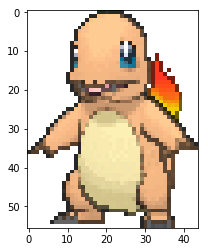

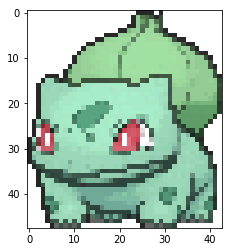

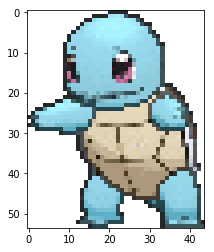

In [8]:
ch = imageio.imread('img/charmander-tight.png')
bb = imageio.imread('img/bulbasaur-tight.png')
sq = imageio.imread('img/squirtle-tight.png')
plt.imshow(ch)
plt.show()
plt.imshow(bb)
plt.show()
plt.imshow(sq)
plt.show()

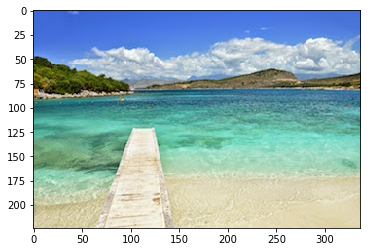

In [9]:
example_backgroud = imageio.imread('img/backgrounds/5.jpg')
plt.imshow(example_backgroud)

## Data Preparation

In [10]:
pokemon_dim = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

# useful store these in an array
pokemon_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

### Creating custom loss function 

In [11]:
def custom_loss(y_true, y_pred):
  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # Location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # Object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # Object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

### Creating model from VGG 16

In [12]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[pokemon_dim, pokemon_dim, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # Location
  x2 = Dense(3, activation='softmax')(x) # Object class
  x3 = Dense(1, activation='sigmoid')(x) # Object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [13]:
from glob import glob

### Loading Backgrounds for generator

In [14]:
backgrounds = []
background_files = glob('img/backgrounds/*.jpg')
for f in background_files:
    bg = np.array(image.load_img(f))
    backgrounds.append(bg)

### Pokemon Image Generator 

In [15]:
def pokemon_generator_multiclass(batch_size=64):
  while True:
    # Each epoch will have 50 batches
    for _ in range(50):
      X = np.zeros((batch_size, pokemon_dim, pokemon_dim, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # Select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - pokemon_dim)
        rnd_w = np.random.randint(bg_w - pokemon_dim)
        X[i] = bg[rnd_h:rnd_h+pokemon_dim,rnd_w:rnd_w+pokemon_dim].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # Choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = pokemon_data[pk_idx]

          # Eesize object 
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # Choose a random location to store the object
          row0 = np.random.randint(pokemon_dim - new_height)
          col0 = np.random.randint(pokemon_dim - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          mask = (obj[:,:,3] == 0) # Find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # Where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # Put the slice back

          # Location
          Y[i,0] = row0/pokemon_dim
          Y[i,1] = col0/pokemon_dim
          Y[i,2] = (row1 - row0)/pokemon_dim
          Y[i,3] = (col1 - col0)/pokemon_dim

          # Class
          Y[i,4 + pk_idx] = 1
        
        # did the pokemon appear?
        Y[i,7] = appear
      
      yield X / 255., Y

### Testing Generator

In [16]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0.21  0.46  0.175 0.14  1.    0.    0.    1.   ]
percent no obj: 0.359375
percent charmander: 0.25
percent bulbasaur: 0.234375
percent squirtle: 0.15625


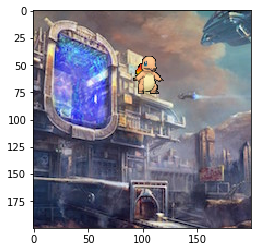

In [17]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

### Training Model

In [18]:
model = make_model()
model.fit(pokemon_generator_multiclass(), 
          steps_per_epoch=50, 
          epochs=5)

Epoch 1/5
50/50 [==============================] - 1932s 39s/step - loss: 0.9098
Epoch 2/5
50/50 [==============================] - 1918s 38s/step - loss: 0.4248
Epoch 3/5
50/50 [==============================] - 1962s 39s/step - loss: 0.4084
Epoch 4/5
50/50 [==============================] - 1971s 39s/step - loss: 0.4134
Epoch 5/5
50/50 [==============================] - 1985s 40s/step - loss: 0.4076


### Prediction method

In [19]:
# Make predictions
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - pokemon_dim)
  rnd_w = np.random.randint(bg_w - pokemon_dim)
  x = bg[rnd_h:rnd_h+pokemon_dim,rnd_w:rnd_w+pokemon_dim].copy()
  
  appear = (np.random.random() < 0.75)
  if appear:

    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = pokemon_data[pk_idx]
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(pokemon_dim - new_height)
    col0 = np.random.randint(pokemon_dim - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    actual_class = class_names[pk_idx]
    print("true:", row0, col0, row1, col1, actual_class)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[-1] > 0.5:
    row0 = int(p[0]*pokemon_dim)
    col0 = int(p[1]*pokemon_dim)
    row1 = int(row0 + p[2]*pokemon_dim)
    col1 = int(col0 + p[3]*pokemon_dim)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred:", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
        (p[1]*pokemon_dim, p[0]*pokemon_dim),
        p[3]*pokemon_dim, p[2]*pokemon_dim,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

true: 146 79 182 108 Squirtle
pred: 151 69 191 96 Squirtle


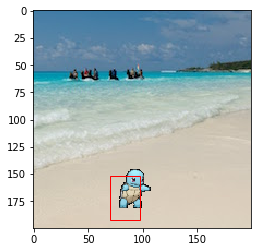

In [21]:
pokemon_prediction_multiclass()

pred: no object


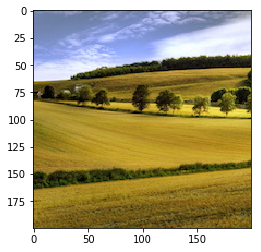

In [22]:
pokemon_prediction_multiclass()

true: 63 0 135 56 Charmander
pred: 64 5 131 51 Charmander


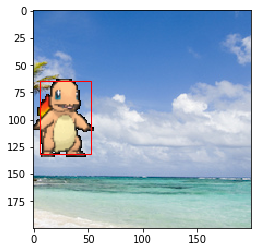

In [23]:
pokemon_prediction_multiclass()

true: 63 137 126 188 Squirtle
pred: 58 127 120 173 Squirtle


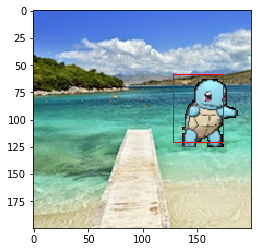

In [28]:
pokemon_prediction_multiclass()